# Sequence restoration with Latent Diffusion Models

In [1]:
import matplotlib.pyplot as plt
import matplotlib
#%matplotlib inline

import os

import numpy as np
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid
from torchvision.transforms.functional import resize

/home/alban/ImSeqCond/.venv_ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's also check what type of GPU we've got.

In [3]:
import os
os.chdir("/home/alban/ImSeqCond/latent-diffusion/")

Load it.

In [4]:
#@title loading utils
import torch
from omegaconf import OmegaConf

from ldm.util import instantiate_from_config


def load_model_from_config(config, ckpt=None):
    model = instantiate_from_config(config.model)
    
    if ckpt is not None:
        print(f"Loading model from {ckpt}")
        pl_sd = torch.load(ckpt)#, map_location="cpu")
        sd = pl_sd["state_dict"]
        m, u = model.load_state_dict(sd, strict=False)
    else:
        print("Instantiated model from config")
        
    model.cuda()
    model.eval()
    return model

#cond_key = 'label'
cond_key = 'LR_image'

def get_model():
    model_folder = "/home/alban/ImSeqCond/latent-diffusion/logs_saved/2023-12-21T00-11-09_config_siar_sr"
    checkpoint = "epoch=000036.ckpt"
    
    files = os.listdir(os.path.join(model_folder, "configs"))
    config_file = ""
    for file in files:
        if file.endswith("project.yaml"):
            config_file = file
            break
    
    if config_file == "":
        raise ValueError("No config file found")
    
    config = OmegaConf.load(os.path.join(model_folder, 'configs', config_file))
    model = load_model_from_config(config, os.path.join(model_folder, "checkpoints", checkpoint))
    return model

In [5]:
from ldm.models.diffusion.ddim import DDIMSampler

model = get_model()
sampler = DDIMSampler(model)

# count model parameters
params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print(f"Model has {params/1e6:.2f}M parameters")

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 113.62 M params.
Keeping EMAs of 308.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from models/first_stage_models/vq-f4/model.ckpt with 0 missing and 55 unexpected keys
Loading model from /home/alban/ImSeqCond/latent-diffusion/logs_saved/2023-12-21T00-11-09_config_siar_sr/checkpoints/epoch=000036.ckpt
Model has 113.62M parameters


In [6]:
# Load some custom data
from ldm.data.siar import SIAR

dataset = SIAR("/home/alban/ImSeqCond/data/SIAR", set_type='val', resolution=256, max_sequence_size=1, downscale_f=4)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False)

Wrong images excluded


And go. Quality, sampling speed and diversity are best controlled via the `scale`, `ddim_steps` and `ddim_eta` variables. As a rule of thumb, higher values of `scale` produce better samples at the cost of a reduced output diversity. Furthermore, increasing `ddim_steps` generally also gives higher quality samples, but returns are diminishing for values > 250. Fast sampling (i e. low values of `ddim_steps`) while retaining good quality can be achieved by using `ddim_eta = 0.0`.

rendering 6 examples of images '5' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:01<00:00, 14.39it/s]


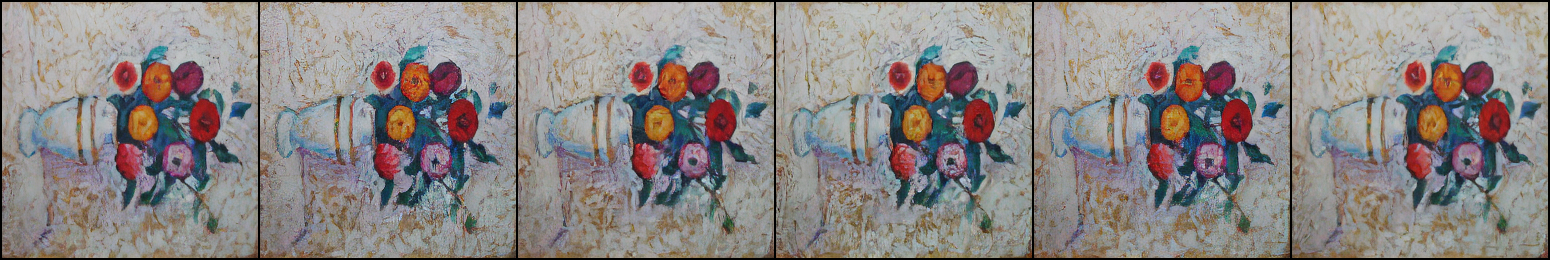

In [7]:
i = 5

images_indexes = [i]
n_samples_per_image = 6

ddim_steps = 20
ddim_eta = 0.0
scale = 3  # for unconditional guidance


all_samples = list()

with torch.no_grad():
    with model.ema_scope():
        
        """ uc = model.get_learned_conditioning(
            {model.cond_stage_key: torch.zeros(n_samples_per_image, 3, 64, 64).cuda().to(model.device)}
            ) """
        
        """ uc = model.get_learned_conditioning(
            torch.zeros(n_samples_per_image, 3, 4, 64, 64).cuda().to(model.device)
            ) """

        for image_index in images_indexes:
            print(f"rendering {n_samples_per_image} examples of images '{image_index}' in {ddim_steps} steps and using s={scale:.2f}.")
            
            if cond_key == 'LR_image':
                xc = rearrange(torch.tensor(dataset[image_index]['LR_image']), 'h w c -> c h w').unsqueeze(0).repeat(n_samples_per_image, 1, 1, 1)
            elif cond_key == 'label':
                xc = rearrange(torch.tensor(dataset[image_index][cond_key]), 's h w c -> c s h w').unsqueeze(0).repeat(n_samples_per_image, 1, 1, 1, 1)
            else:
                raise ValueError(f"Unknown cond_key '{cond_key}'")

            c = model.get_learned_conditioning(xc.to(model.device))

            samples_ddim, _ = sampler.sample(S=ddim_steps,
                                             conditioning=c,
                                             batch_size=n_samples_per_image,
                                             shape=[3, 64, 64],
                                             verbose=False,
                                             unconditional_guidance_scale=scale,
                                             #unconditional_conditioning=uc,
                                             eta=ddim_eta)

            x_samples_ddim = model.decode_first_stage(samples_ddim)
            x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0,
                                         min=0.0, max=1.0)
            all_samples.append(x_samples_ddim)


# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_image)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))

In [8]:
def plot_image(data, predict=None):
    """ For a single data point, plot the ground truth image, the input images and the predicted image
    Args:
        gt (torch.tensor): ground truth image
        input (torch.tensor): input images
        predict (torch.tensor): predicted image
    """
    gt, input = data['data'], data['label']
    
    label_images = data['label'].shape[0]
    
    fig, axes = plt.subplots(2, 6, figsize=(20, 10))

    axes[0, 0].imshow(gt)
    axes[0, 0].set_title("Ground truth")
    
    for i in range(label_images):
        axes[i//5, i%5 + 1].imshow(input[i])
        axes[i//5, i%5 + 1].set_title("Input " + str(i+1))
        
    if predict is not None:
        axes[1, 0].imshow(predict)
        axes[1, 0].set_title("Predicted")
        
    plt.show()

In [9]:
def prepare_for_plot(data, all_samples=None):
    
    data_prepared = dict()
    for key, value in data.items():
        if key in ['data', 'label']:
            data_prepared[key] = (value + 1) / 2
    
    predict_prepared = rearrange(all_samples[0][0], 'c h w -> h w c')
    #predict_prepared = (predict_prepared + 1) / 2
    predict_prepared = predict_prepared.cpu().detach().numpy()
    
    return data_prepared, predict_prepared

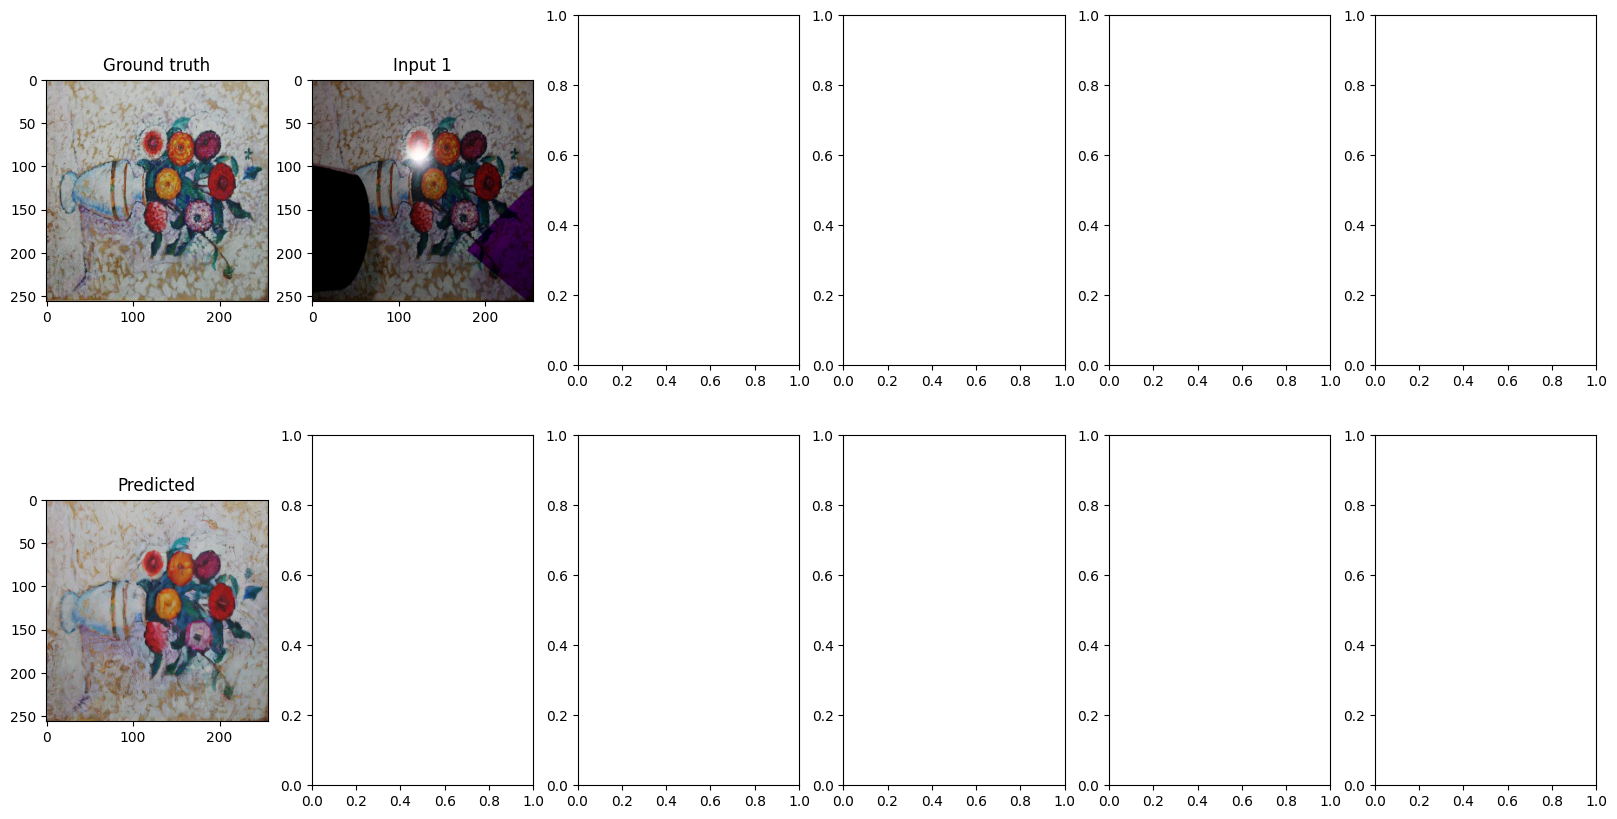

In [10]:
plot_image(*prepare_for_plot(dataset[i], all_samples))

In [11]:
# STUDY OF THE LATENT SPACE

""" cond = c[0]

# convert cond in 0, 1
cond = (cond - cond.min()) / (cond.max() - cond.min())
cond = rearrange(cond, 'c h w -> h w c')
cond = cond.detach().cpu().numpy()

cond_decode = model.decode_first_stage(c[0].unsqueeze(0))

cond_decode = torch.clamp((cond_decode+1.0)/2.0,
                                        min=0.0, max=1.0)
cond_decode = rearrange(cond_decode.squeeze(), 'c h w -> h w c')
cond_decode = cond_decode.detach().cpu().numpy()


fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(cond)
axes[0].set_title("Cond in latent space")

axes[1].imshow(cond_decode)
axes[1].set_title("Cond in pixel space") """

' cond = c[0]\n\n# convert cond in 0, 1\ncond = (cond - cond.min()) / (cond.max() - cond.min())\ncond = rearrange(cond, \'c h w -> h w c\')\ncond = cond.detach().cpu().numpy()\n\ncond_decode = model.decode_first_stage(c[0].unsqueeze(0))\n\ncond_decode = torch.clamp((cond_decode+1.0)/2.0,\n                                        min=0.0, max=1.0)\ncond_decode = rearrange(cond_decode.squeeze(), \'c h w -> h w c\')\ncond_decode = cond_decode.detach().cpu().numpy()\n\n\nfig, axes = plt.subplots(1, 2, figsize=(20, 10))\n\naxes[0].imshow(cond)\naxes[0].set_title("Cond in latent space")\n\naxes[1].imshow(cond_decode)\naxes[1].set_title("Cond in pixel space") '

In [15]:
from benchmark import Benchmark

class BenchmarkLDM(Benchmark):
    
    def __init__(self, model, dataloader, mse=True, clip=False, lpips=False, cond_key='label'):
        super().__init__(model, dataloader, mse, clip, lpips, cond_key)
    
    def sample(self, data):
        """ Method used to sample from the model with the data as conditionning 
            Args:
                data (torch.tensor): conditionning data. size: (batch_size, 3, W, H) or (batch_size, 10, 3, W, H)
            Output:
                torch.tensor: restored image. size: (batch_size, 3, W, H)
        """
        
        ddim_steps = 200
        ddim_eta = 0.0
        scale = 1   # for unconditional guidance
        
        if self.cond_key == 'LR_image':
            xc = rearrange(torch.tensor(data), 'b h w c -> b c h w')
        elif self.cond_key == 'label':
            xc = rearrange(torch.tensor(data), 'b s h w c -> b c s h w')
        else:
            raise ValueError(f"Unknown cond_key '{cond_key}'")

        c = model.get_learned_conditioning(xc.to(model.device))

        samples_ddim, _ = sampler.sample(S=ddim_steps,
                                            conditioning=c,
                                            batch_size=data.shape[0],
                                            shape=[3, 64, 64],
                                            verbose=False,
                                            unconditional_guidance_scale=scale,
                                            eta=ddim_eta)

        x_samples_ddim = model.decode_first_stage(samples_ddim)
        x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0,
                                        min=0.0, max=1.0)
    
        return x_samples_ddim

In [16]:
benchmark = BenchmarkLDM(model, dataloader, mse=True, clip=True, lpips=True, cond_key=cond_key)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/alban/ImSeqCond/.venv_ldm/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


In [17]:
results = benchmark.evaluate()

Evaluating model on metrics mse, clip, lpips


  0%|          | 0/361 [00:00<?, ?it/s]/tmp/ipykernel_3757095/1109985535.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xc = rearrange(torch.tensor(data), 'b h w c -> b c h w')


Data shape for DDIM sampling is (4, 3, 64, 64), eta 0.0
Running DDIM Sampling with 200 timesteps


  0%|          | 1/361 [00:09<55:48,  9.30s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 0.0
Running DDIM Sampling with 200 timesteps


  1%|          | 2/361 [00:19<58:04,  9.71s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 0.0
Running DDIM Sampling with 200 timesteps


  1%|          | 3/361 [00:28<55:23,  9.28s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 0.0
Running DDIM Sampling with 200 timesteps


  1%|          | 4/361 [00:37<55:02,  9.25s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 0.0
Running DDIM Sampling with 200 timesteps


  1%|▏         | 5/361 [00:46<55:05,  9.28s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 0.0
Running DDIM Sampling with 200 timesteps


  2%|▏         | 6/361 [00:55<53:56,  9.12s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 0.0
Running DDIM Sampling with 200 timesteps


  2%|▏         | 7/361 [01:04<53:19,  9.04s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 0.0
Running DDIM Sampling with 200 timesteps


  2%|▏         | 8/361 [01:13<52:48,  8.98s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 0.0
Running DDIM Sampling with 200 timesteps


  2%|▏         | 9/361 [01:21<52:27,  8.94s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 0.0
Running DDIM Sampling with 200 timesteps


  3%|▎         | 10/361 [01:30<52:02,  8.90s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 0.0
Running DDIM Sampling with 200 timesteps


  3%|▎         | 11/361 [01:39<51:35,  8.84s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 0.0
Running DDIM Sampling with 200 timesteps


  3%|▎         | 12/361 [01:48<51:19,  8.82s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 0.0
Running DDIM Sampling with 200 timesteps


  4%|▎         | 13/361 [01:56<50:48,  8.76s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 0.0
Running DDIM Sampling with 200 timesteps


  4%|▍         | 14/361 [02:05<50:01,  8.65s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 0.0
Running DDIM Sampling with 200 timesteps


  4%|▍         | 14/361 [02:07<52:44,  9.12s/it]


KeyboardInterrupt: 